# PAC Simulation with inflation

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import seaborn
from datetime import datetime
from matplotlib.ticker import MaxNLocator

In [2]:
# NET is the taxation applied to the dividends of the ETFs
etf_list = {
    "MSCI USA":"https://raw.githubusercontent.com/paolocole/Stock-Indexes-Historical-Data/main/NET/EUR/LARGE_AND_MID_CAP/COUNTRIES/MSCI%20USA.csv",
    "MSCI Europe":"https://raw.githubusercontent.com/paolocole/Stock-Indexes-Historical-Data/main/NET/EUR/LARGE_AND_MID_CAP/REGIONS/MSCI%20EUROPE.csv",
    "MSCI Emerging Asia":"https://raw.githubusercontent.com/paolocole/Stock-Indexes-Historical-Data/main/NET/EUR/LARGE_AND_MID_CAP/REGIONS/MSCI%20EM%20ASIA.csv",
    "MSCI World":"https://raw.githubusercontent.com/paolocole/Stock-Indexes-Historical-Data/main/NET/EUR/LARGE_AND_MID_CAP/REGIONS/MSCI%20WORLD.csv"
}

data = {}
for etf in etf_list:
    etf_df = pd.read_csv(etf_list[etf])
    print("\n"+etf)
    print(etf_df.iloc[:,1].pct_change(12).describe())
    data[etf] = etf_df


MSCI USA
count    284.000000
mean       0.078899
std        0.180555
min       -0.405395
25%       -0.008967
50%        0.095027
75%        0.195189
max        0.480247
Name: USA, dtype: float64

MSCI Europe
count    284.000000
mean       0.058190
std        0.183306
min       -0.437690
25%       -0.063136
50%        0.095155
75%        0.180827
max        0.531722
Name: EUROPE, dtype: float64

MSCI Emerging Asia
count    260.000000
mean       0.099963
std        0.219275
min       -0.531884
25%       -0.025135
50%        0.088911
75%        0.229136
max        0.734873
Name: EM ASIA, dtype: float64

MSCI World
count    284.000000
mean       0.070279
std        0.176151
min       -0.393967
25%       -0.016887
50%        0.086533
75%        0.188740
max        0.495063
Name: WORLD, dtype: float64


## Parameters

In [13]:
savings = 1000
savings_increase = 0.03
index = "MSCI World"
tax_rate = 0.26
bollo = 0.002
years = [10, 20, 30 ,40, 50]

In [14]:
monthly_returns = list(data[index].iloc[:,1].pct_change(1).iloc[1:])
monthly_savings_increase = (1+savings_increase)**(1/12)-1
numbers_of_months = years[-1]*12 # 50 years * 12 months

# Real net capital (Capitale netto reale)
real_net_capital = np.zeros((numbers_of_months, len(monthly_returns)))
print(f"Real net capital shape: {real_net_capital.shape}")

# Payments (Versamenti)
payments = np.zeros(numbers_of_months)
payments[0] = savings
real_net_capital[0] = payments[0]
print(f"Payments shape: {payments.shape}")

# Populate payments array
for month in range(1, numbers_of_months):
    payments[month] = payments[month-1]*(1+monthly_savings_increase)

for month in range(1, numbers_of_months):
    payments[month] = payments[month] - ( real_net_capital[month-1, simulation] * bollo if month%12==0 else 0 ) # il bollo si paga solo a fine anno e quindi il mese dopo avro' un versamento ridotto per il bollo pagato
    for simulation in range(len(monthly_returns)):
        # Quando finiscono i mesi si ricomincia dall'inizio con i rendimenti
        simulation_x = (simulation+month) % len(monthly_returns)
        # capitale netto reale = versamenti + capitale netto reale mese precedente * (1 + rendimento mensile)
        real_net_capital[month, simulation] = payments[month] + real_net_capital[month-1, simulation] * (1 + monthly_returns[simulation_x]) 
        

Real net capital shape: (600, 295)
Payments shape: (600,)


In [15]:
real_net_capital

array([[1.00000000e+03, 1.00000000e+03, 1.00000000e+03, ...,
        1.00000000e+03, 1.00000000e+03, 1.00000000e+03],
       [2.00932468e+03, 2.06146595e+03, 2.06301490e+03, ...,
        2.03874067e+03, 2.02523141e+03, 2.05894647e+03],
       [3.13281281e+03, 3.19122351e+03, 3.02106668e+03, ...,
        3.09009150e+03, 3.14455549e+03, 3.07800618e+03],
       ...,
       [9.07996371e+06, 8.88116063e+06, 9.42336271e+06, ...,
        8.94846810e+06, 9.43592558e+06, 9.02192938e+06],
       [8.92159636e+06, 9.46948980e+06, 1.01163656e+07, ...,
        9.47428461e+06, 9.06793981e+06, 9.12838137e+06],
       [9.51259508e+06, 1.01658743e+07, 1.09879497e+07, ...,
        9.10479593e+06, 9.17492320e+06, 8.96915705e+06]])

10 years: #payments: 136.90K  -  min 102.46K  avg 181.92K  max 266.18K


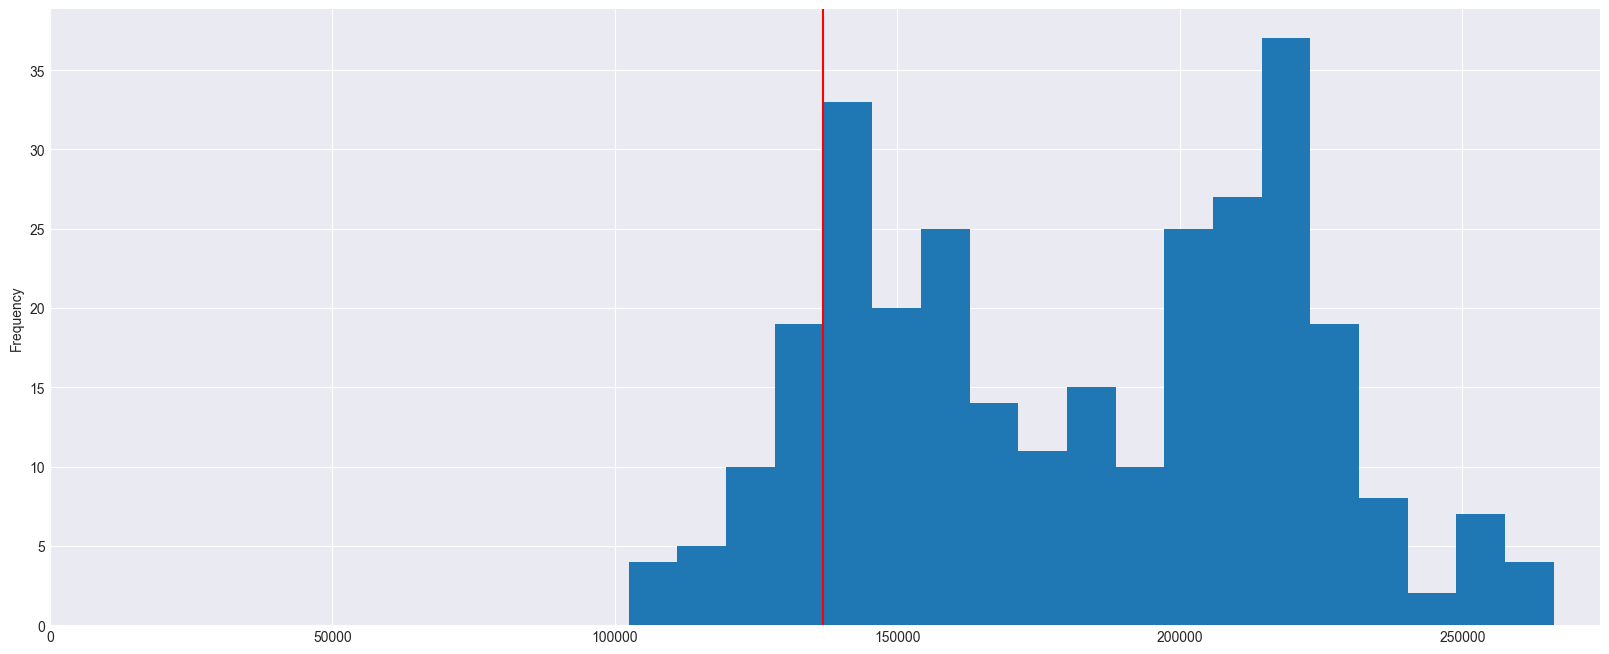

20 years: #payments: 317.42K  -  min 290.09K  avg 552.48K  max 985.88K


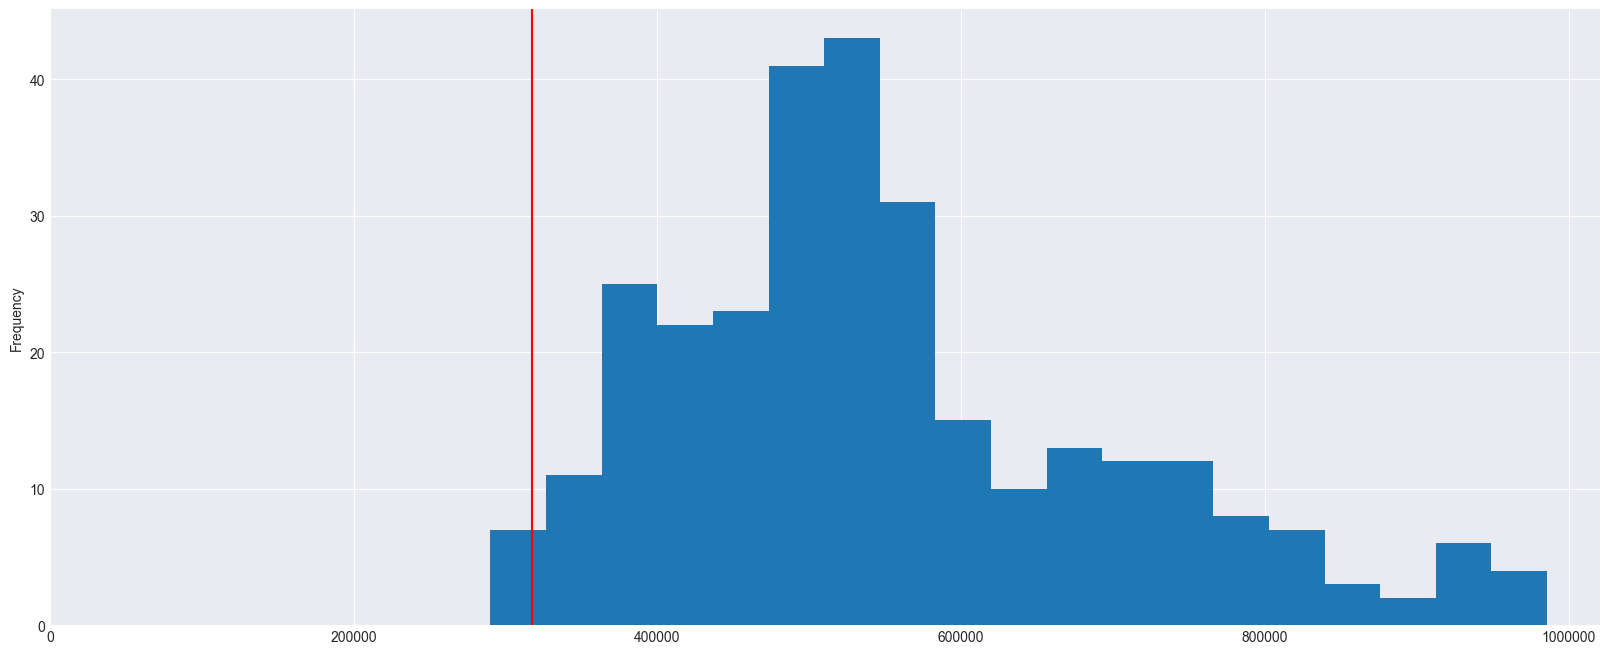

30 years: #payments: 544.50K  -  min 698.96K  avg 1226.14K  max 2062.18K


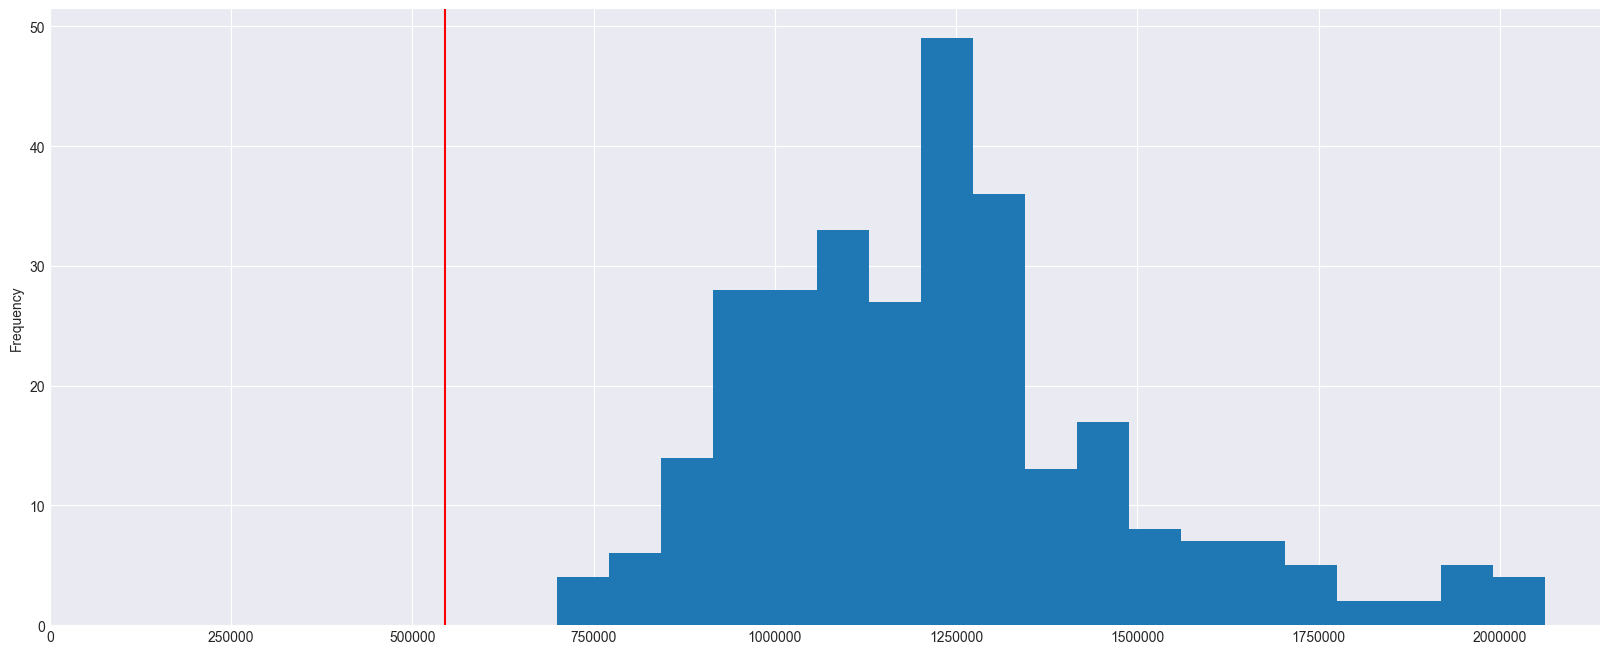

40 years: #payments: 848.68K  -  min 1300.06K  avg 2561.98K  max 4587.08K


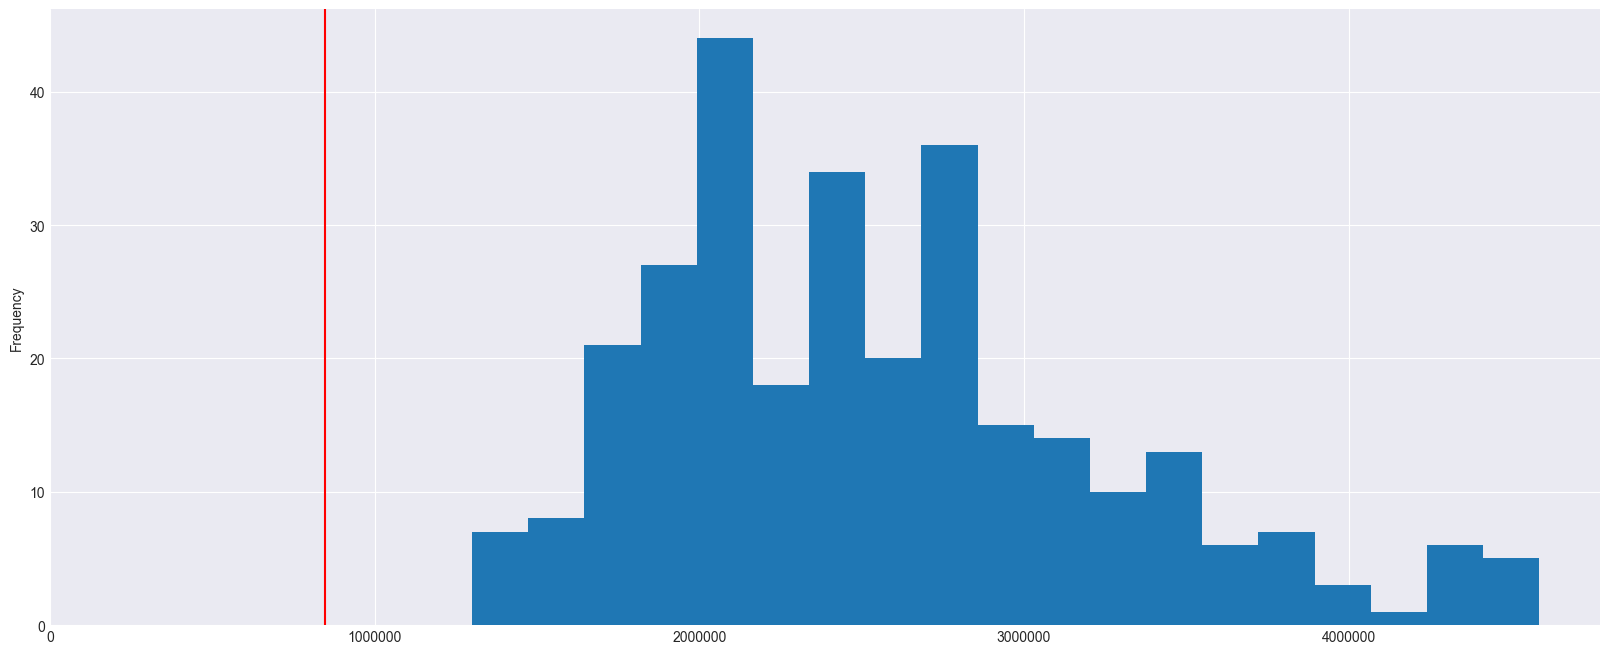

50 years: #payments: 1207.13K  -  min 2679.04K  avg 4947.71K  max 8990.31K


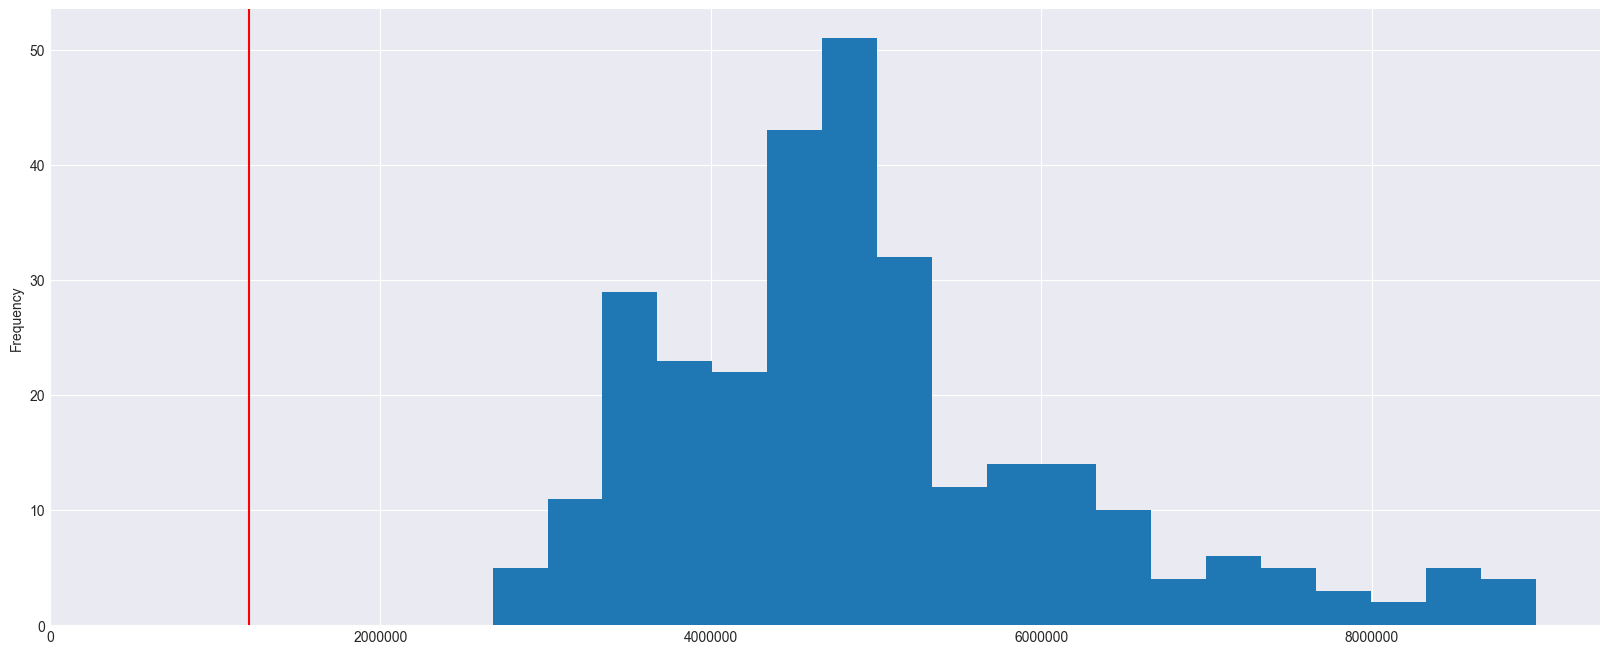

In [16]:
# Calcolo annuale del capitale netto reale
for year in years:
    print(f"{year} years", end=": ")
    c = real_net_capital[year*12-1]
    p = sum(payments[:year*12-1])
    tax = ( c - p ) * tax_rate
    net = c - tax
    print(f"#payments: {p/1000:.2f}K  -  min {net.min()/1000:.2f}K  avg {net.mean()/1000:.2f}K  max {net.max()/1000:.2f}K")

    pd.DataFrame(net).plot(kind='hist',legend=None,bins=int(len(net)/15),figsize=(20,8))
    plt.axvline(x = p, color='r', label='Payments')
    plt.xlim(xmin=0)
    plt.ticklabel_format(style='plain')
    plt.show()

## Simulation with inflation

In [17]:
# Two new parameters are added to the simulation:
inflation_forecast = "real_scaled" # "fixed", "real", "real_scaled", "lognormal"
inflation_rate = 0.03

In [18]:
monthly_returns = list(data[index].iloc[:,1].pct_change(1).iloc[1:])
monthly_savings_increase = (1+savings_increase)**(1/12)-1
numbers_of_months = years[-1]*12 # 50 years * 12 months

# Real net capital (Capitale netto reale)
real_net_capital = np.zeros((numbers_of_months, len(monthly_returns)))
print(f"Real net capital shape: {real_net_capital.shape}")

# Payments (Versamenti)
payments = np.zeros(numbers_of_months)
payments[0] = savings
real_net_capital[0] = payments[0]
print(f"Payments shape: {payments.shape}")

# Populate payments array
for month in range(1, numbers_of_months):
    payments[month] = payments[month-1]*(1+monthly_savings_increase)

for month in range(1, numbers_of_months):
    payments[month] = payments[month] - ( real_net_capital[month-1, simulation] * bollo if month%12==0 else 0 ) # il bollo si paga solo a fine anno e quindi il mese dopo avro' un versamento ridotto per il bollo pagato
    for simulation in range(len(monthly_returns)):
        # Quando finiscono i mesi si ricomincia dall'inizio con i rendimenti
        simulation_x = (simulation+month) % len(monthly_returns)
        # capitale netto reale = versamenti + capitale netto reale mese precedente * (1 + rendimento mensile)
        real_net_capital[month, simulation] = payments[month] + real_net_capital[month-1, simulation] * (1 + monthly_returns[simulation_x]) 

Real net capital shape: (600, 295)
Payments shape: (600,)


In [24]:
# Inflation forecast
n_simulation = 100 # (50, 295, 100) = 28,900 simulations
# Inflazione Istat
real_inflation = np.array([2.3,3.4,1.3,2.8,-0.4,2.3,2.1,4.7,7.5,5.9,4.6,2.3,3.7,1.4,2.6,5.0,4.8,5.7,10.8,19.1,17.0,16.8,17.0,12.1,14.8,
                             21.2,17.8,16.5,14.7,10.8,9.2,5.8,4.8,5.0,6.3,6.5,6.2,5.3,4.7,4.1,5.3,4.0,2.0,2.0,1.7,2.5,2.7,2.5,2.7,2.2,1.9,
                             2.1,1.8,3.3,0.8,1.5,2.7,3.0,1.2,0.2,0.1,-0.1,1.2,1.2,0.6,-0.2,1.9,8.1,8.7])/100
if inflation_forecast == "fixed":
    inflation = np.ones((years[-1],len(monthly_returns),n_simulation))*inflation_rate  # (years, months, simulations)
elif inflation_forecast == "real":
    inflation = real_inflation[np.random.randint(0,len(real_inflation)),(years[-1],len(monthly_returns),n_simulation)]
elif inflation_forecast == "real_scaled":
    inflation = (real_inflation*(inflation_rate/real_inflation.mean()))[np.random.randint(0,len(real_inflation),(years[-1],len(monthly_returns),n_simulation))]
elif inflation_forecast == "lognormal":
    mu = np.log(real_inflation)
    sigma = np.log((1+np.sqrt(1+4*real_inflation.var()/np.exp(2*mu)))/2)
    mu = np.log(real_inflation) - sigma**2/2
    sigma = np.log((1+np.sqrt(1+4*real_inflation.var()/np.exp(2*mu)))/2)
    mu = np.log(real_inflation) - sigma**2/2
    inflation = np.random.lognormal(mean=mu, sigma=sigma, size=(years[-1],len(monthly_returns),n_simulation))
else:
    print("Inflation forecast not recognized")
    inflation = np.array([inflation_rate, inflation_rate, inflation_rate])
print(f"Avg inflation: {inflation.mean()}  Dev. Std. inflation: {inflation.std()}")
print(f"Inflation shape: {inflation.shape}")


Avg inflation: 0.029953030133529224  Dev. Std. inflation: 0.02911970705283227
Inflation shape: (50, 295, 100)


10 years: #payments: 119.17K  -  min 58.70K  avg 136.40K  max 238.50K


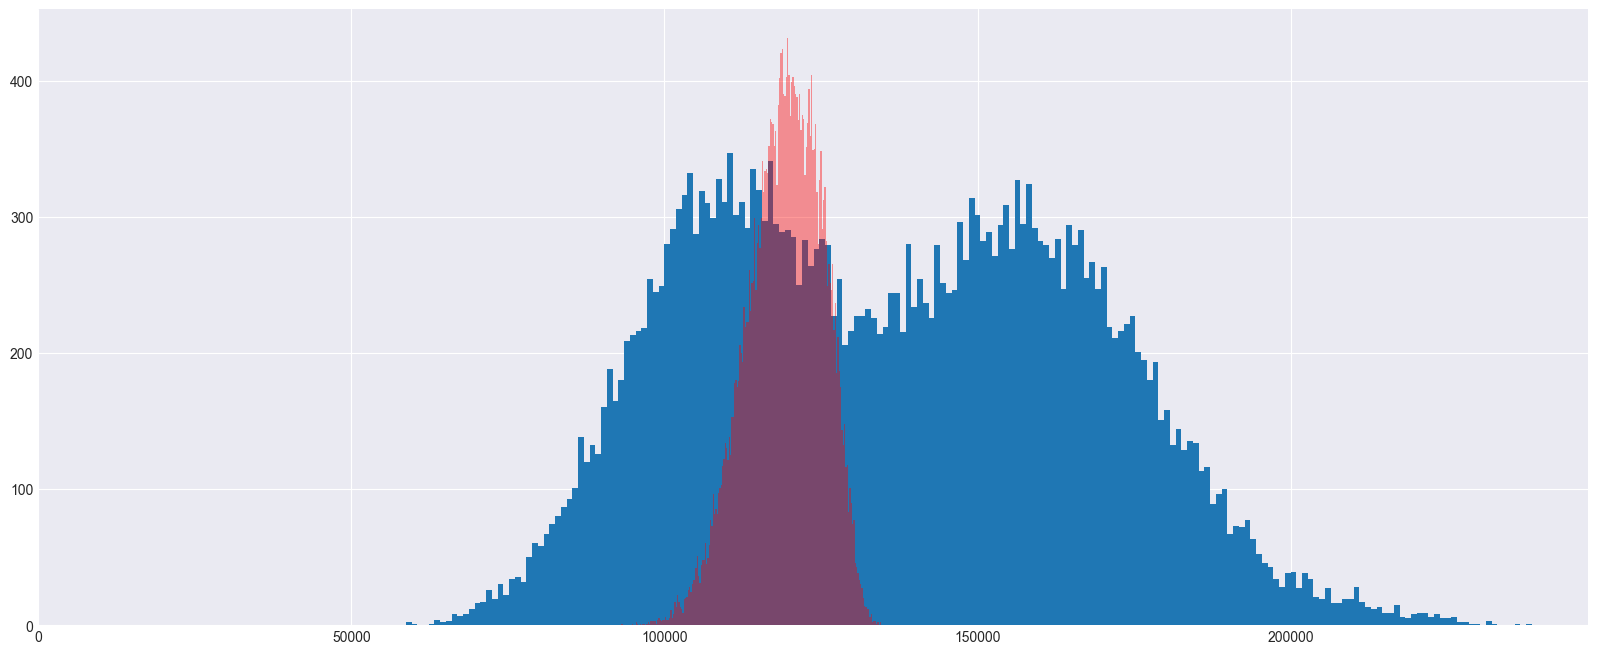

20 years: #payments: 236.25K  -  min 114.16K  avg 310.90K  max 743.55K


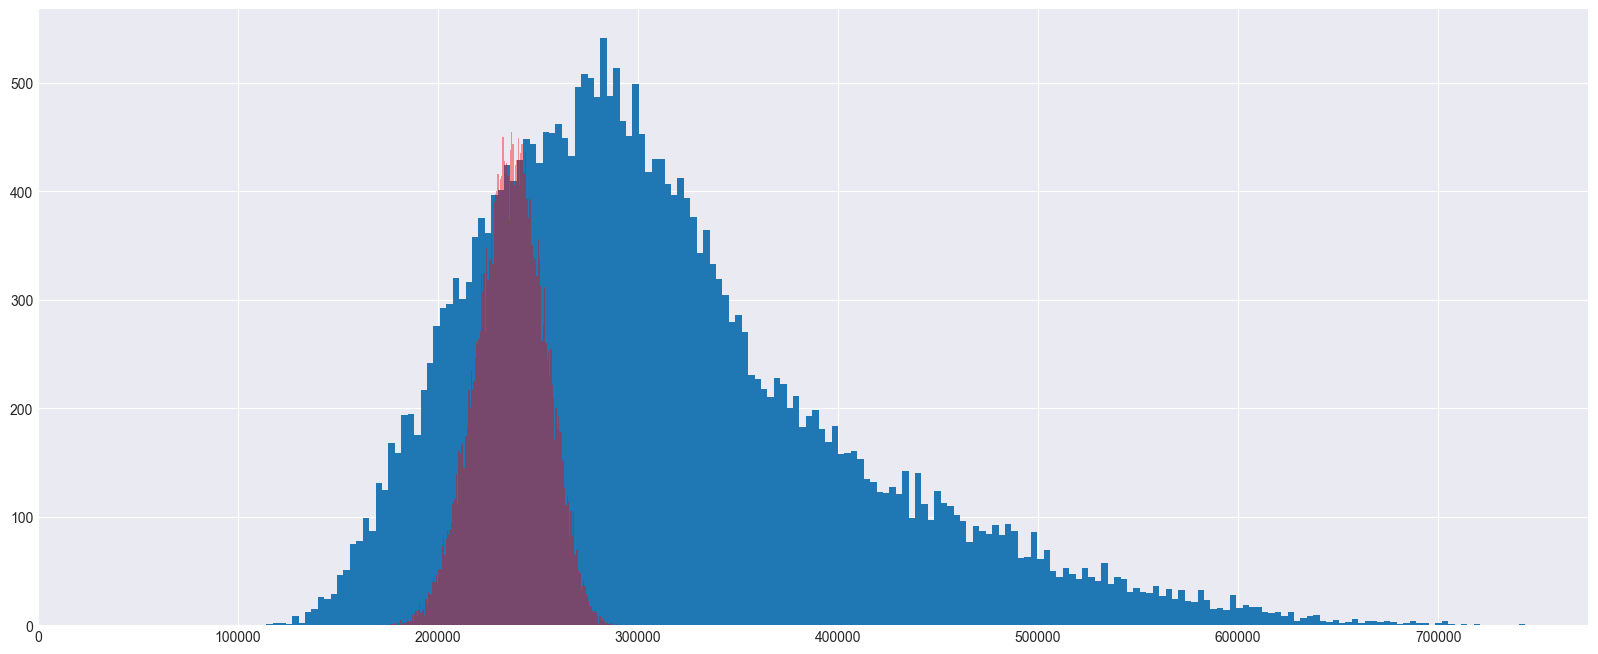

30 years: #payments: 346.64K  -  min 178.26K  avg 517.61K  max 1231.22K


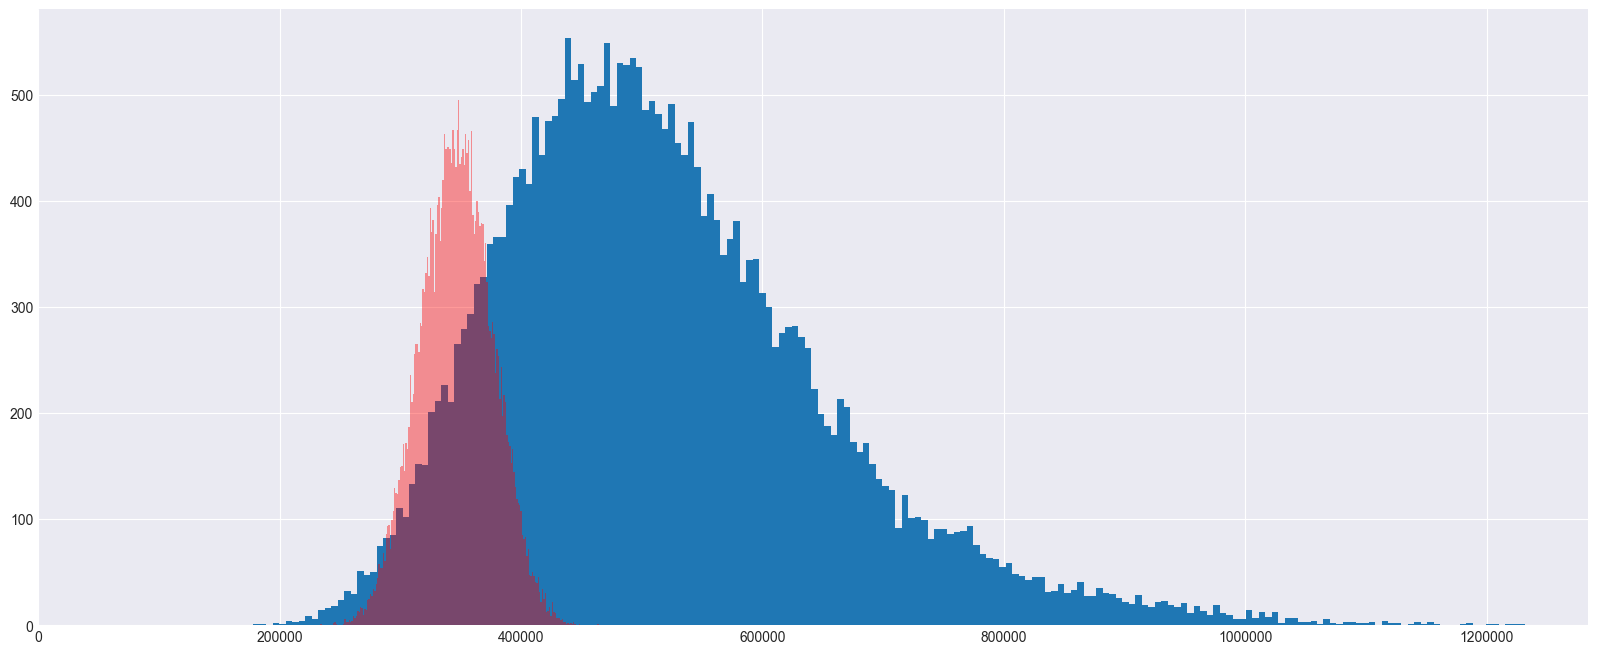

40 years: #payments: 457.54K  -  min 224.81K  avg 812.01K  max 2295.10K


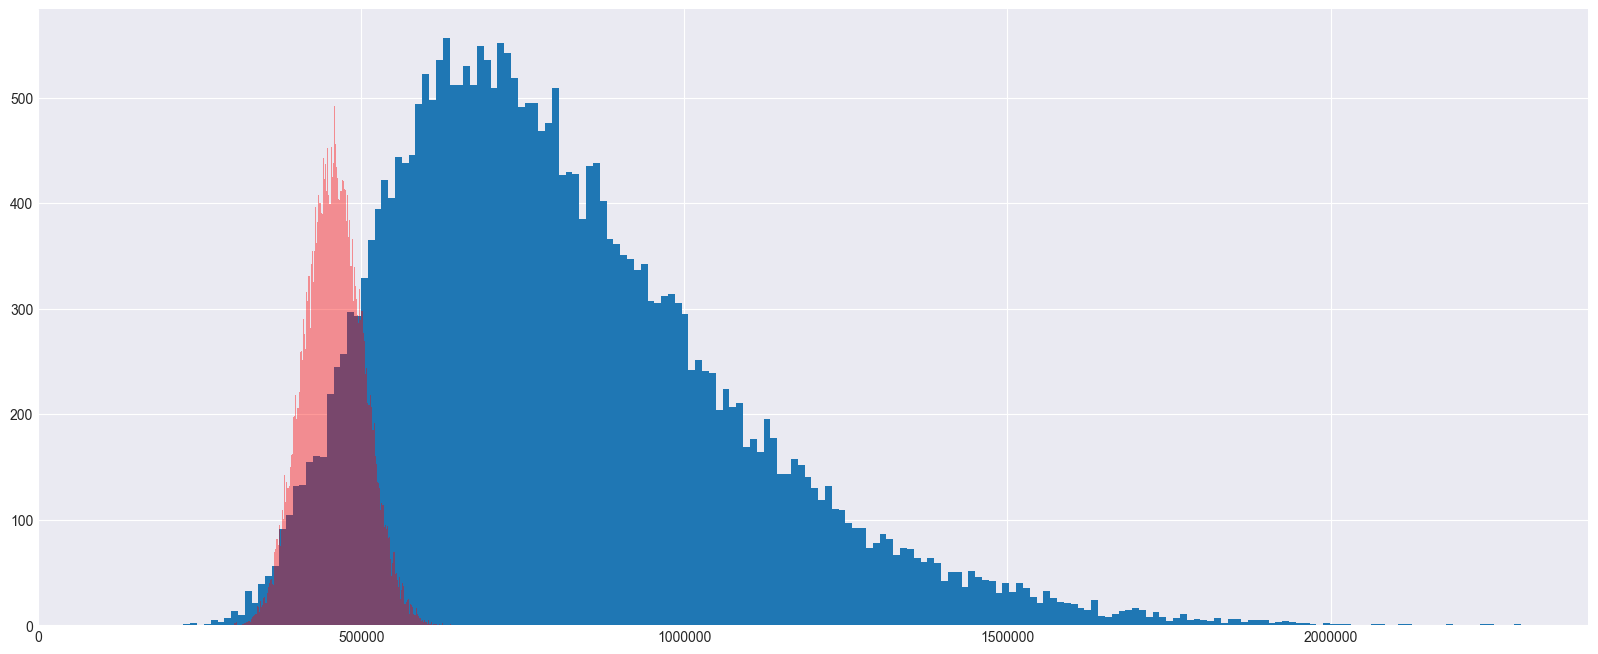

50 years: #payments: 555.83K  -  min 336.49K  avg 1175.35K  max 3845.37K


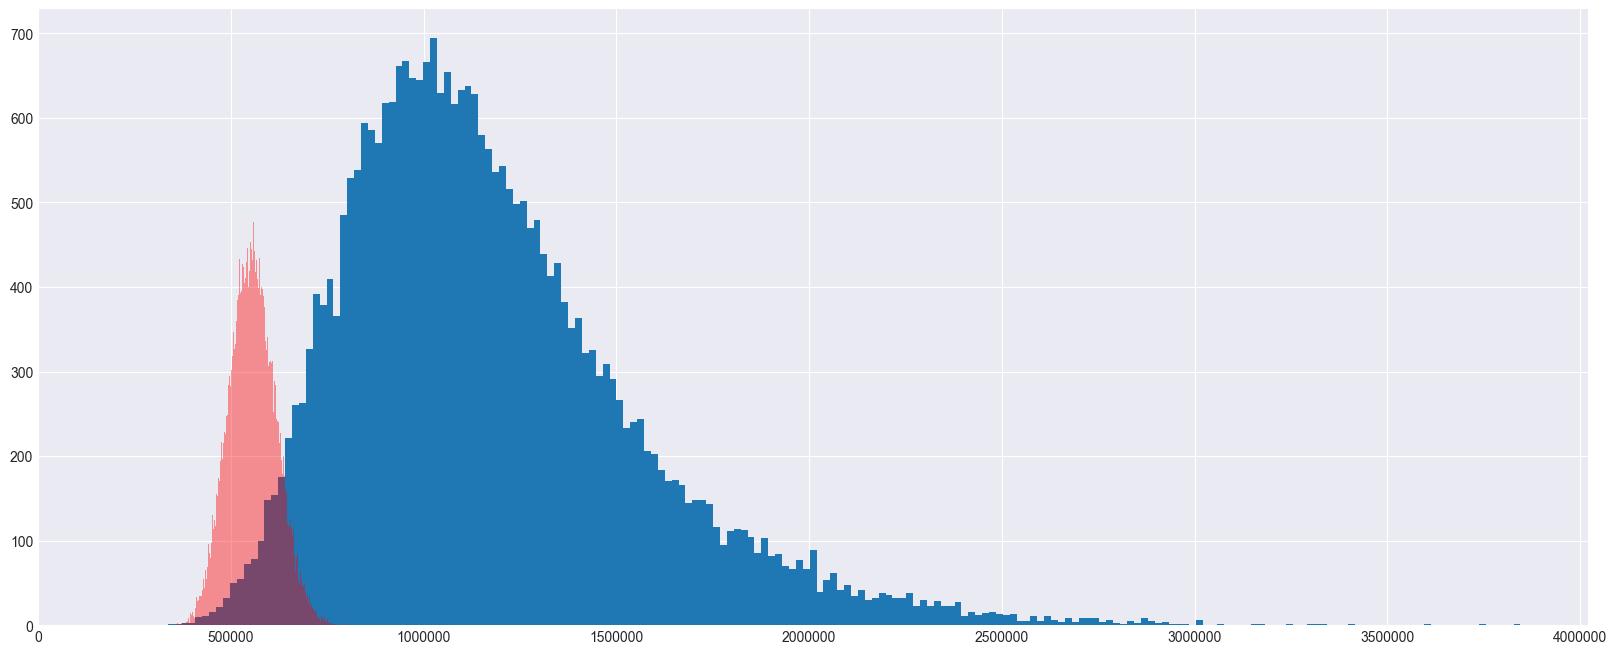

In [27]:
# Calcolo annuale del capitale netto reale
for year in years:
    print(f"{year} years", end=": ")
    c = real_net_capital[year*12-1]
    p = sum(payments[:year*12-1])
    tax = ( c - p ) * tax_rate
    net = c - tax

    # Calcolo dell'inflazione fino all'anno corrente
    inflation_until_current_year = np.ones((len(monthly_returns),n_simulation))
    for i in range(year):
        inflation_until_current_year = inflation_until_current_year * (1+inflation[i,:,:])
    
    # Calcolo del capitale netto reale
    matrix = np.expand_dims(net, axis=-1) / inflation_until_current_year
    net = np.reshape(matrix, matrix.shape[0]*matrix.shape[1])

    # Calcolo dei versamenti reali, ogni versamento tiene conto dell'inflazione al momento del versamento
    p = np.zeros(inflation.shape[1]*inflation.shape[2])
    inflation_until_now = np.ones((inflation.shape[1]*inflation.shape[2]))
    for a in range(year):
        monthly_inflation = (np.reshape(inflation[a,:,:],(inflation.shape[1]*inflation.shape[2]))+1) ** (1/12)
        for m in range(12):
            inflation_until_now *= monthly_inflation
            p += payments[m+a*12] / inflation_until_now
    
    # Plot dei risultati della simulazione
    print(f"#payments: {p.mean()/1000:.2f}K  -  min {net.min()/1000:.2f}K  avg {net.mean()/1000:.2f}K  max {net.max()/1000:.2f}K")
    plt.figure(figsize=(20,8))
    if inflation_forecast == "fixed":
        plt.hist(pd.DataFrame(net), bins=int(len(net)/1500))
        plt.axvline(x = p[0], color='r', label='Payments')
    else:
        plt.hist(pd.DataFrame(net), bins=int(len(net)/150))
        plt.hist(pd.DataFrame(p), bins=int(len(p)/150), color='r', alpha=0.4)
    plt.xlim(xmin=0)
    plt.ticklabel_format(style='plain')
    plt.show()

# Risultati in termini reali
# Inflazione maggiore -> Capitale netto reale minore
# Inflazione minore -> Capitale netto reale maggiore
# In Rosso i versamenti reali
# In Blu il capitale netto reale